In [2]:
'''
__author__ = 'Alex Cheng'
惩罚线性回归-多分类

玻璃样本
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets,linear_model
from sklearn.metrics import roc_curve,auc,roc_auc_score
from math import sqrt

In [3]:
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/"
             "glass/glass.data")
df = pd.read_csv(target_url,header=None,sep=",",prefix='V')
#df = pd.read_csv(target_url,header=0,sep=",")
df.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [13]:
df['V10'].unique()

array([1, 2, 3, 5, 6, 7], dtype=int64)

In [4]:
df['V10'].value_counts() # unblance label

2    76
1    70
7    29
3    17
5    13
6     9
Name: V10, dtype: int64

In [5]:
names = ['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type']

In [20]:
xList  = np.array(df.iloc[:,:-1]) # 属性数组
labels = [i for i in df.iloc[:,-1]] # 最后一列就是label
nrows = len(xList)
ncols = len(xList[0])

# 创建 one versus all 标签向量,就是one-hot向量编码啦
yOneVALL = []
labelSet = set(labels)
labelList = list(labelSet)
labelList.sort() # [1, 2, 3, 5, 6, 7]
nlabels = len(labelList)
for i in range(nrows):
    yRow = [0.0] * nlabels
    index = labelList.index(labels[i]) # 标签值在list对应的索引位置
    yRow[index] = 1.0
    yOneVALL.append(yRow)  

In [42]:
# 正则化columns in x and labels
nrows = len(xList)
ncols = len(xList[0])

# 计算means and variance
xMeans = []
xSD = []
for i in range(ncols):
    col = [xList[j][i] for j in range(nrows)]
    mean = sum(col)/nrows
    xMeans.append(mean)
    colDiff = sum((col - mean) **2)
    
    colDiff2 = [(xList[j,i] - mean) for j in range(nrows) ]
    sumSq = sum([colDiff2[i]  * colDiff2[i] for i in range(nrows)])
    stdDev2 = sqrt(sumSq/nrows)
    
    stdDev = sqrt(colDiff/nrows)
    xSD.append(stdDev)
#print(xMeans,'\n',xSD)
print(stdDev == stdDev2) # broadcast广播变量的方式，发现结果一样


# 正则化xList
xNorm = []
for i in range(nrows):
    #rowNorm = ([xList[i] - xMeans]) / xSD  #列表不支持
    rowNorm = [(xList[i,j] - xMeans[j]) / xSD[j] for j in range(ncols)]
    xNorm.append(rowNorm)

# 正则化 labels
#meanLable = sum(labels)/ nrows
#sdLabel = sqrt(sum([ (labels[i] - meanLable) * (labels[i] - meanLable) for i in range(nrows)]) / nrows)
#labelNorm = [ (labels[i] - meanLable) / sdLabel for i in range(nrows) ]
# 多标签

yMeans = []
ySD = []
for i in range(nlabels):
    col = [yOneVALL[j][i] for j in range(nrows)]
    mean = sum(col)/nrows
    colDiff = [(yOneVALL[j][i] - mean) for j in range(nrows)]
    sumSq = sum([colDiff[i] * colDiff[i] for i in range(nrows)])
    stdDev = sqrt(sumSq/nrows)
    yMeans.append(mean)
    ySD.append(stdDev)

yNorm = []
for i in range(nrows):
    rowNorm = [(yOneVALL[i][j] - yMeans[j]) / ySD[j] for j in range(nlabels)]
    yNorm.append(rowNorm)
print(len(yNorm),len(yNorm[0]))

True
214 6


Min error % :  0.26635514018691586 alpha index:  392


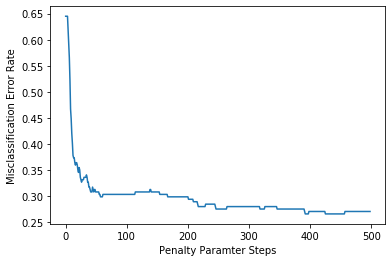

In [58]:
# cross-validation folds
nxval = 10
nAlphas = 500
misClass = [0.0] * nAlphas

for ixval in range(nxval): # 交叉验证
    # Define test and traing index sets
    idxTest =  [i for i in range(nrows) if i % nxval == ixval]
    idxTrain = [i for i in range(nrows) if i % nxval != ixval]
    #idxTest =  [i for i in range(nrows) if i % nxval ==0]
    #idxTrain = [i for i in range(nrows) if i % nxval !=0]

    # 定义测试和训练的属性和列表
    xTrain = [xNorm[r] for r in idxTrain]
    xTest  = [xNorm[r] for r in idxTest]
    yTrain = [yNorm[r] for r in idxTrain]
    yTest  = [yNorm[r] for r in idxTest] # 列向量
    labelTest = [labels[r] for r in idxTest] # 用于后面预测和真实的y分类比较
    
     # 为one-hot标签每一列创建模型
    models = []
    lenTrain = len(yTrain)
    lenTest = nrows - lenTrain
    for imodel in range(nlabels): #d 多标签
        ytemp = np.array([yTrain[j][imodel] for j in range(lenTrain)]) # 每列标签
        # 训练次数为200时警告不能收敛 ConvergenceWarning: Objective did not converge
        models.append(linear_model.enet_path(xTrain,ytemp,l1_ration=1.0,fit_intercept=False,
                     eps=0.5e-3, n_alphas=nAlphas,return_models=False)) # 每列y的预测， 
        
    
    for step in range(1,nAlphas): # 第一轮是
        allPred = [] # 每个alpha下面的预知
        for model in range(nlabels):
            _,coefs,_ = models[model]
            predTemp = list(np.dot(xTest,coefs[:,step])) # coef : col * 200， 每列的预测
            # 数据之前被正则化了，
            predUnNorm = [(predTemp[j] * ySD[model] + yMeans[model]) for j in range(len(predTemp))]
            allPred.append(predUnNorm) # nlabels * len(test)
            
        predictions = []
        for i in range(lenTest): # 最大值位置要，和yTest的每行比较，
            listOfPred = [allPred[j][i] for j in range(nlabels)]
            
            # 注意，不是要求值相等，因为是one-hot编码，所以每行的预测的最大值对应的位置，再去找查找字典labelList
            idxMax = listOfPred.index(max(listOfPred)) 
            # 不能收敛，ConvergenceWarning: Objective did not converge
            #if labelList[idxMax] != yTest[i]: 
            if labelList[idxMax] != labelTest[i]: # 预测(在标签字典中) ！= 真实y值
                misClass[step] += 1.0

misClassPlot = [misClass[i] / nrows for i in range(1,nAlphas)] ## 第一个没有计算，默认为0
#print(misClass) 
print('Min error % : ',min(misClassPlot), 'alpha index: ',misClassPlot.index(min(misClassPlot)))

plt.plot(misClassPlot)
plt.xlabel("Penalty Paramter Steps")
plt.ylabel("Misclassification Error Rate")
plt.show()